#  Input and explore  data

In [4]:
#import module
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.cm as cm

import pandas as pd
import numpy as np
import missingno
import datetime


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from statsmodels.tsa.stattools import coint
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from kneed import KneeLocator
from sklearn import metrics
from datetime import datetime


In [5]:
#input data
data=pd.read_csv("data_in_TW_stock_colab.csv")
data = data.pivot(index='Date', columns='stock_code', values = 'Adj Close')

In [6]:
data.info()
mask=data.loc['2017-01-01':'2022-07-01']
print('Including missing values in data: {}'.format(data.isnull().values.any()))

<class 'pandas.core.frame.DataFrame'>
Index: 3593 entries, 2008-01-02 to 2022-08-08
Columns: 965 entries, 1101.TW to 9958.TW
dtypes: float64(965)
memory usage: 26.5+ MB
Including missing values in data: True


In [7]:
print('Total missing data: {}'.format(mask.isna().sum()))

Total missing data: stock_code
1101.TW    4
1102.TW    4
1103.TW    4
1104.TW    4
1108.TW    4
          ..
9944.TW    4
9945.TW    4
9946.TW    4
9955.TW    4
9958.TW    4
Length: 965, dtype: int64


<AxesSubplot:>

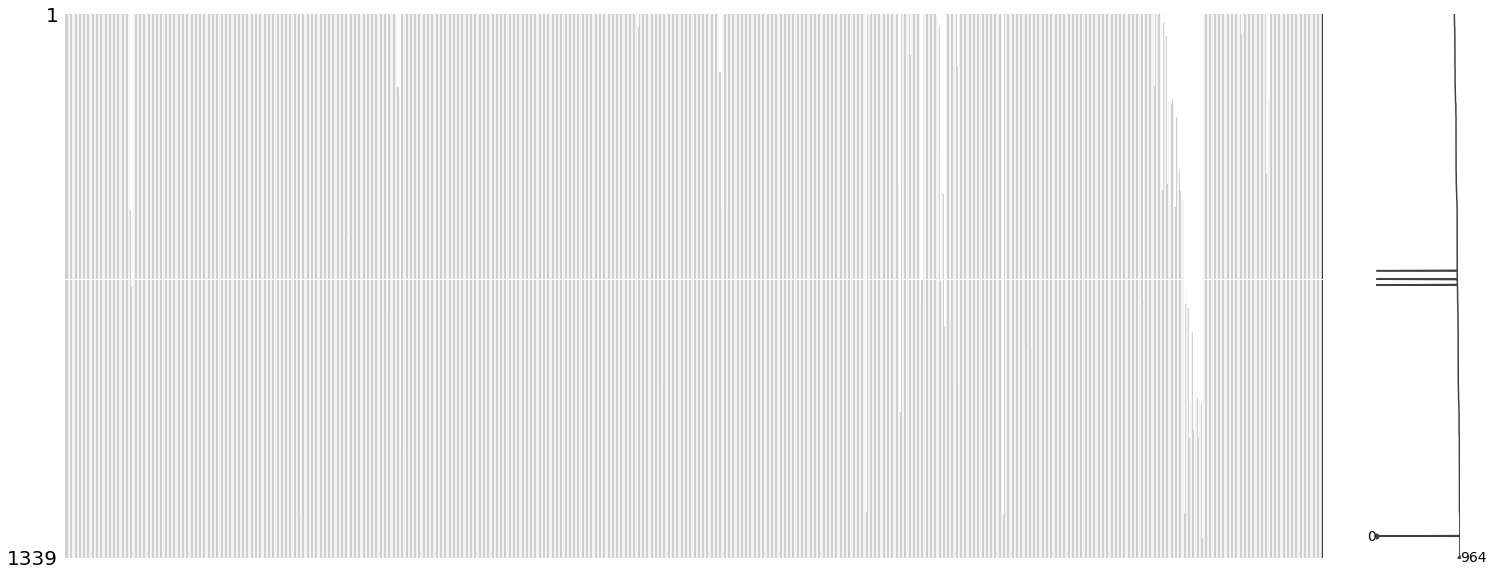

In [8]:
#visualize the missing values
#missingno.matrix(data)
missingno.matrix(mask)

In [9]:
#drop columns with too many missing values (more than 10% of data are missing)
print('Data Shape before cleaning =', mask.shape)

missing_percentage = mask.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.10].index))
mask.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', mask.shape)

Data Shape before cleaning = (1339, 965)
Data Shape after cleaning = (1339, 907)


C:\Users\Lora\AppData\Local\Temp/ipykernel_8072/3349643355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask.drop(labels=dropped_list, axis=1, inplace=True)


<AxesSubplot:>

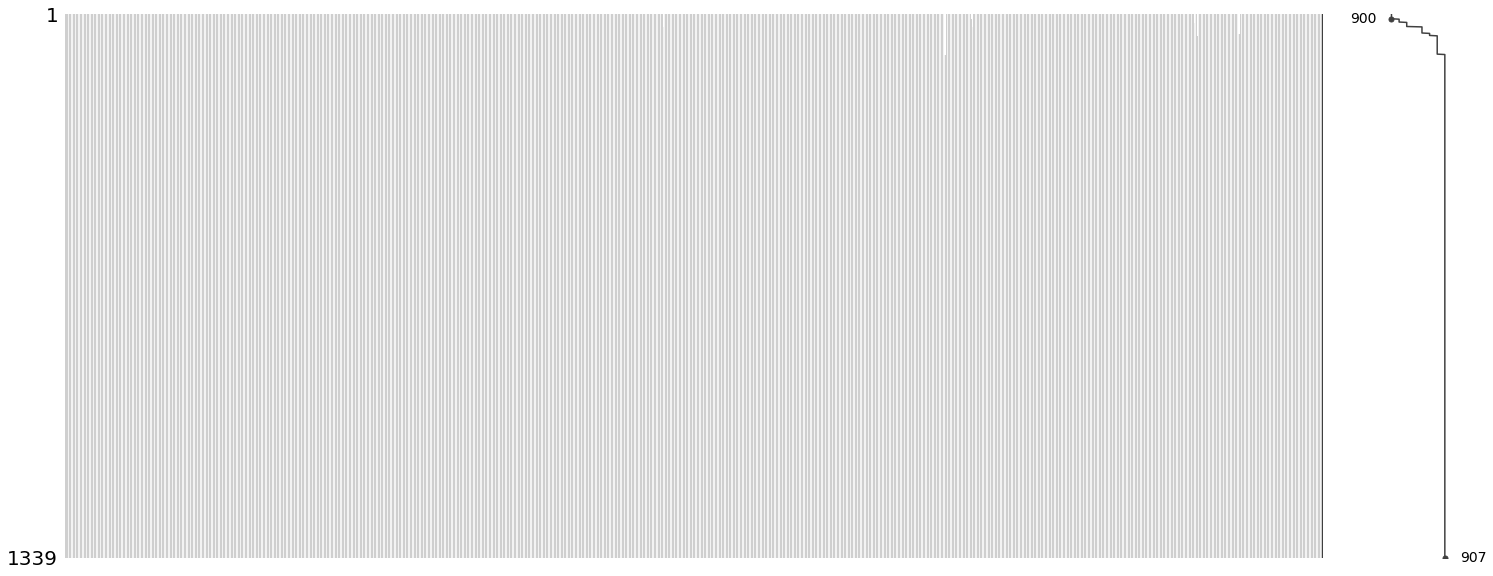

In [10]:
#fill the missing values by the last available value in the column
mask= mask.fillna(method='pad',axis=0)
missingno.matrix(mask)

In [11]:
# train test split 
mask, test_mask = train_test_split(mask, test_size=0.3, shuffle=False)

In [12]:
#calculate returns and create a data frame
returns=pd.DataFrame(mask.pct_change().mean()*252)
returns.columns = ['returns']

#calculate the volatility
returns['volatility'] = mask.pct_change().std()*np.sqrt(252)

data = returns
data.head()

,returns,volatility
stock_code,,
1101.TW,0.180851,0.212944
1102.TW,0.202577,0.235491
1103.TW,0.239724,0.257237
1104.TW,0.017642,0.138868
1108.TW,0.096977,0.206160


In [13]:
#Standardization
#prepare the scaler
scale = StandardScaler().fit(data)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data),columns = data.columns, index = data.index)
X = scaled_data
X.head()

,returns,volatility
stock_code,,
1101.TW,0.169443,-0.452334
1102.TW,0.279022,-0.362121
1103.TW,0.466380,-0.275116
1104.TW,-0.653726,-0.748715
1108.TW,-0.253585,-0.479475


# Use k-Means Clustering for Pairs Trading

### To find the best parameter in cluster analysis

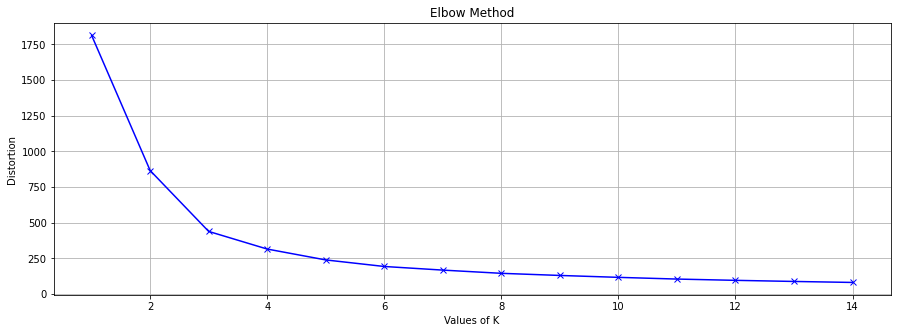

In [14]:
#set parameter and call empty Memory
#Using ELBOW method
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [15]:
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

3

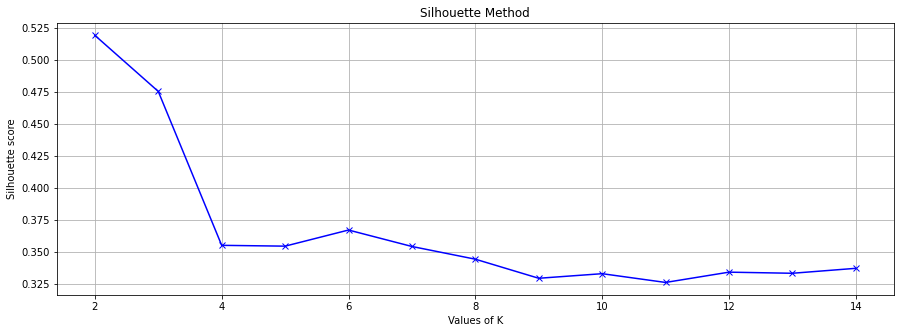

Suggested number of clusters:  4


In [16]:
#Silhouette methods are used to find the optimal number of clusters
K = range(2,15) #k needs to start from 2
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

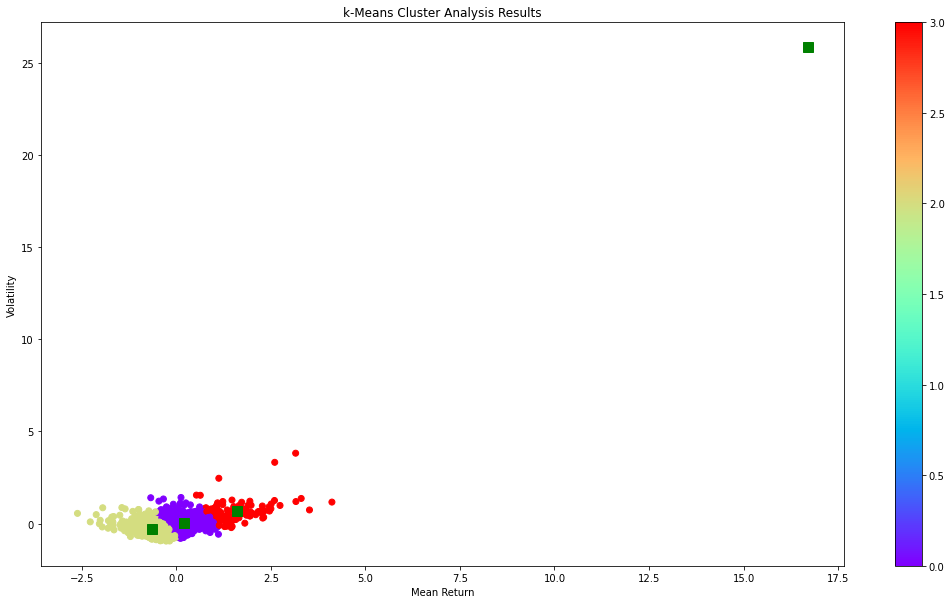

In [17]:
c = 4
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
# plt.xlim(-2,25)
# plt.ylim(-2,20)
plt.show()

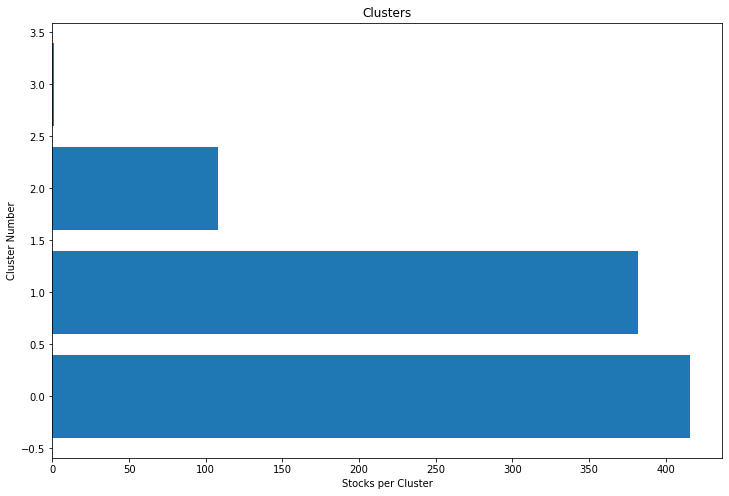

In [18]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [19]:
print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))

k-Means Clustering 0.35532985806737766


#  Identification of Cointegrated Pairs of Stocks

In [20]:
cluster_size_limit = 500
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 3
Number of Pairs: 329738


### To validate the cointegration relationship

In [21]:
# build function provided to get the list of pairs
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score

            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
        return score_matrix, pvalue_matrix, pairs
# print(score_matrix, pvalue_matrix, pairs)

In [22]:
#testing for cointegration for all possible pairs 
cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    
    try:
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(mask[tickers])
        cluster_dict[clust] = {}
        cluster_dict[clust]['score_matrix'] = score_matrix
        cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
        cluster_dict[clust]['pairs'] = pairs
    except:
        continue
        
pairs = []   
pvalues=[]
score=[]
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    pvalues.extend(cluster_dict[cluster]['pvalue_matrix'])
    score.extend(cluster_dict[cluster]['score_matrix'])

print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
pairs


Number of pairs: 10
In those pairs, we found 11 unique tickers.


[('1101.TW', '1210.TW'),
 ('1101.TW', '1443.TW'),
 ('1101.TW', '2020.TW'),
 ('1101.TW', '2468.TW'),
 ('1101.TW', '2884.TW'),
 ('1101.TW', '2889.TW'),
 ('1101.TW', '2923.TW'),
 ('1101.TW', '3005.TW'),
 ('1101.TW', '3528.TW'),
 ('1101.TW', '6214.TW')]

In [23]:
stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]
X_pairs.head()

,returns,volatility
stock_code,,
1101.TW,0.169443,-0.452334
1210.TW,0.382248,-0.436356
1443.TW,0.640433,0.067250
2020.TW,0.032022,-0.640131
2468.TW,-0.008901,-0.090275


### Visualization of Pairs

C:\Users\Lora\miniconda3\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Lora\AppData\Local\Temp/ipykernel_8072/1113986306.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');


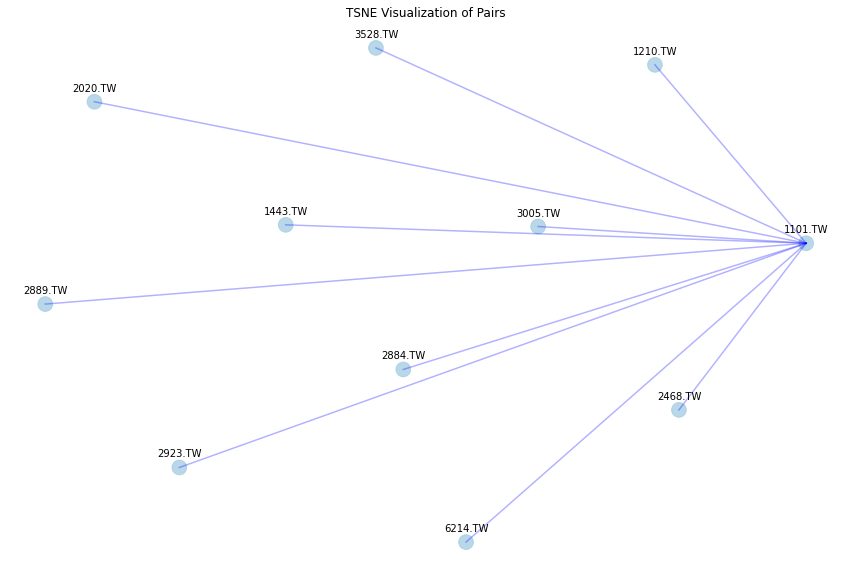

In [24]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X_pairs)
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

# Join pairs by x and y
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):
    label = name
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

# Detecting stationarity for the Selected Pair

In [25]:
X_pairs

,returns,volatility
stock_code,,
1101.TW,0.169443,-0.452334
1210.TW,0.382248,-0.436356
1443.TW,0.640433,0.067250
2020.TW,0.032022,-0.640131
2468.TW,-0.008901,-0.090275
2884.TW,0.291181,-0.630563
2889.TW,0.163240,-0.747094
2923.TW,-0.024722,0.007317
3005.TW,0.036880,-0.236196


In [26]:
# choose the pair to test strategy
asset1 = '1101.TW'
asset2 = '1210.TW'

In [27]:
train = pd.DataFrame()
train['asset1'] = mask[asset1]
train['asset2'] = mask[asset2]

In [28]:
train.isnull().mean()

asset1    0.0
asset2    0.0
dtype: float64

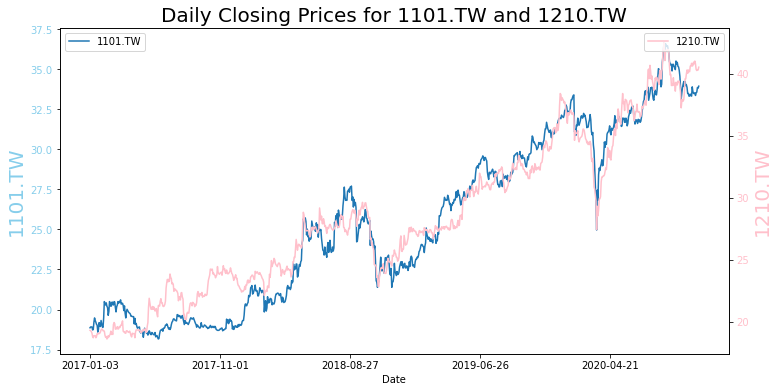

In [29]:
#visualize closing prices
ax = train['asset1'].plot(figsize=(12, 6),label=asset1)
ax.set_ylabel(asset1,color='skyblue',fontsize=20)
ax.tick_params(axis='y',labelcolor='skyblue')
ax.legend(loc='upper left',fontsize=10)
ax.set_title(label= 'Daily Closing Prices for {} and {}'.format(asset1,asset2),fontsize=20)
# ax2 and ax1 will have common x axis and different y axis
ax2=ax.twinx() 
ax2.plot(train[['asset2']],color='pink',label=asset2)
ax2.set_ylabel(asset2,color='pink',fontsize=20)
ax2.tick_params(axis='y',labelcolor='pink')
ax2.legend(loc='upper right',fontsize=10)


In [30]:
# OLS in Differences (OLSD)
results=sm.OLS(train.asset2, train.asset1).fit()

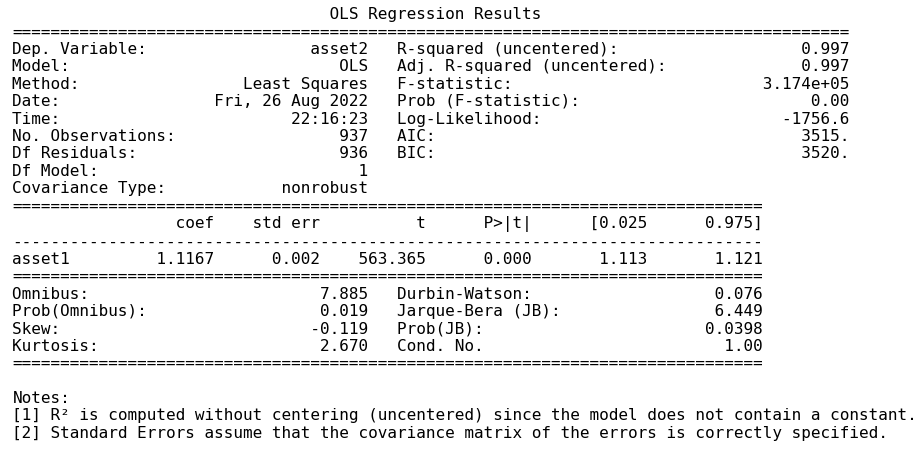

In [31]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)


Hedge Ratio =  1.1167308077907816


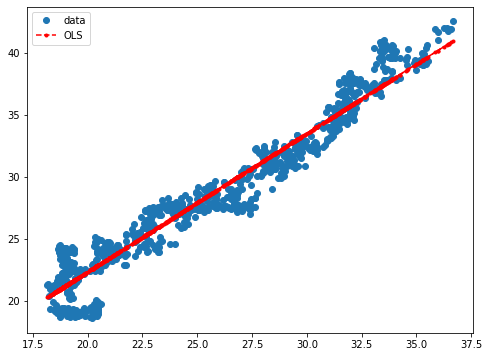

In [32]:
#plot regression model
train_asset2_fitted = results.fittedvalues
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train.asset1, train.asset2, 'o', label='data')
ax.plot(train.asset1, train_asset2_fitted, 'r--.',label='OLS')
ax.legend(loc='best')
#print Hedge Ratio 
Hedge_Ratio= results.params[0]
print('Hedge Ratio = ', Hedge_Ratio)

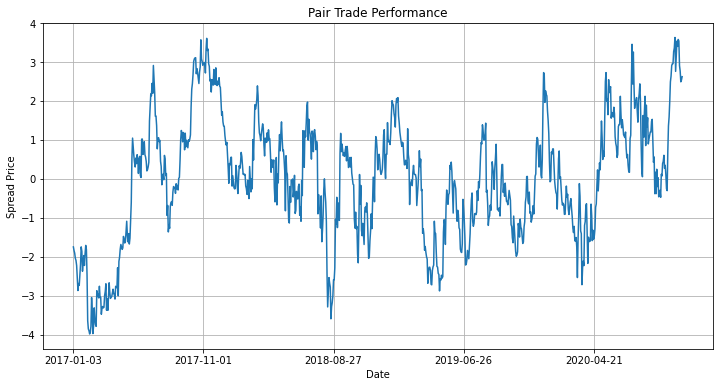

In [33]:
# spread between assets
spread = train.asset2 - Hedge_Ratio * train.asset1
# visualize the spread
plt.figure(figsize=(9, 5))
ax = spread.plot(figsize=(12, 6), title = "Pair Trade Performance")
ax.set_ylabel("Spread Price")
ax.grid(True);

In [34]:
# if the critical value is above the value at 0.05, the spread is considered stationary
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])
# probablity critical values
print(adf[4])

Critical Value =  -3.8945711493407984
{'1%': -3.437363201927513, '5%': -2.864636122077874, '10%': -2.5684185607252137}


# Generate Trading Signals for testing data

In [35]:
# calculate z-score
def zscore(spread):
    return (spread - spread.mean()) / np.std(spread)

In [36]:
# build DataFrame space for trading signals(Out-sample data)
trading_signals = pd.DataFrame()
trading_signals['asset1'] = test_mask[asset1] 
trading_signals['asset2'] = test_mask[asset2]
ratios = trading_signals.asset1 / trading_signals.asset2

In [37]:
# Bollinger Band with upper and lower thresholds
trading_signals['Z'] = zscore(ratios)
trading_signals['Band upper limit'] = np.mean(trading_signals['Z']) + np.std(trading_signals['Z'])
trading_signals['Band lower limit'] = np.mean(trading_signals['Z']) - np.std(trading_signals['Z'])

In [38]:
# build signal 
# when the signal was greater than the upper limit, short the asset
# when the signal was drawdown than the lower limit, long the asset
trading_signals['signals1'] = 0
trading_signals['signals1'] = np.select([trading_signals['Z'] > \
trading_signals['Band upper limit'], trading_signals['Z'] < trading_signals['Band lower limit']], [-1, 1], default=0)

In [39]:
#portfolio position in the stock
trading_signals['positions1'] = trading_signals['signals1'].diff()
trading_signals['signals2'] = -trading_signals['signals1']
trading_signals['positions2'] = trading_signals['signals2'].diff()

In [40]:
trading_signals

,asset1,asset2,Z,Band upper limit,Band lower limit,signals1,positions1,signals2,positions2
Date,,,,,,,,,
2020-11-06,33.774296,40.389023,0.926618,1.0,-1.0,0,NaN,0,NaN
2020-11-09,34.022331,40.523651,1.028147,1.0,-1.0,-1,-1.0,1,1.0
2020-11-10,34.353043,41.196800,0.855294,1.0,-1.0,0,1.0,0,-1.0
2020-11-11,35.262512,41.690445,1.217996,1.0,-1.0,-1,-1.0,1,1.0
2020-11-12,35.055817,41.421185,1.233432,1.0,-1.0,-1,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...
2022-06-27,35.228134,47.799999,-2.087545,1.0,-1.0,1,0.0,-1,0.0
2022-06-28,35.051109,47.900002,-2.246534,1.0,-1.0,1,0.0,-1,0.0
2022-06-29,35.006851,47.450001,-2.064076,1.0,-1.0,1,0.0,-1,0.0


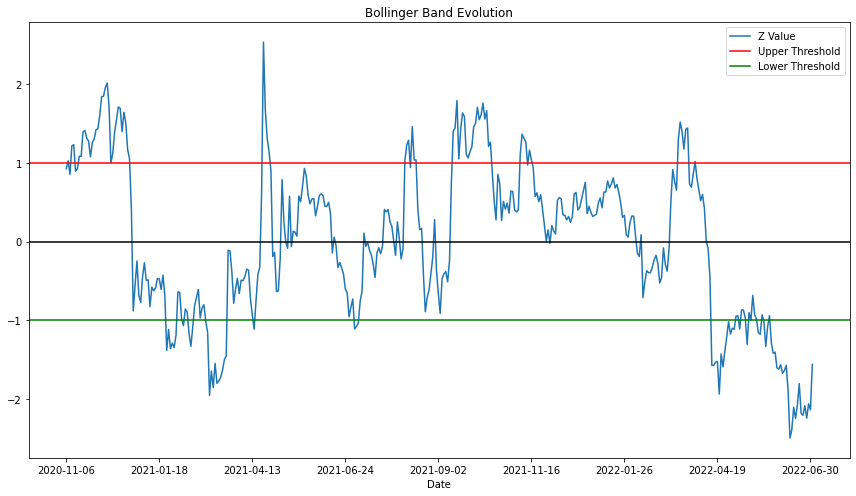

In [41]:
#visualize Bollinger Band with upper and lower thresholds  
trading_signals['Z'].plot(label="Z Value")
plt.title("Bollinger Band Evolution")
plt.axhline(trading_signals['Z'].mean(),color="black")
plt.axhline(trading_signals['Band upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(trading_signals['Band lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()


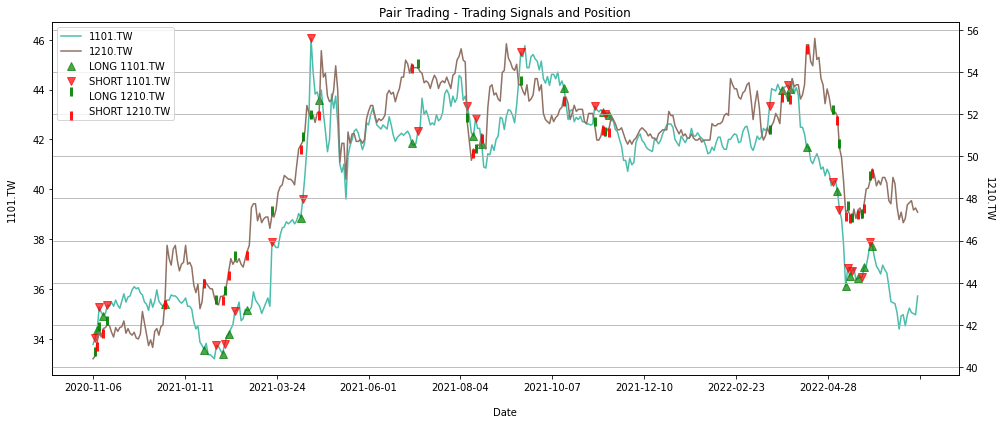

In [42]:
#visualize trading signals and position

fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(trading_signals['asset1'], c='#4abdac')
l2, = bx2.plot(trading_signals['asset2'], c='#907163')

tick_spacing = trading_signals['asset1'].index.size/9 # x
bx.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))

u1, = bx.plot(trading_signals['asset1'][trading_signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(trading_signals['asset1'][trading_signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(trading_signals['asset2'][trading_signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(trading_signals['asset2'][trading_signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

# Profit and Loss in strategy

In [43]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(trading_signals['asset1'])
positions2 = initial_capital// max(trading_signals['asset2'])

In [44]:
# since there are two assets, we calculate each asset Pnl 
# separately and in the end, we aggregate them into one portfolio
# Profit and Loss for the 1st asset
portfolio = pd.DataFrame()
portfolio['asset1'] = trading_signals['asset1']
portfolio['holdings1'] = trading_signals['positions1'].cumsum() * trading_signals['asset1'] * positions1   
portfolio['cash1'] = initial_capital - (trading_signals['positions1'] * trading_signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = trading_signals['positions1']

In [46]:
# Profit and Loss for the 2nd asset
portfolio['asset2'] = trading_signals['asset2']
portfolio['holdings2'] = trading_signals['positions2'].cumsum() * trading_signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (trading_signals['positions2'] * trading_signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = trading_signals['positions2']

In [47]:
trading_signals

,asset1,asset2,Z,Band upper limit,Band lower limit,signals1,positions1,signals2,positions2
Date,,,,,,,,,
2020-11-06,33.774296,40.389023,0.926618,1.0,-1.0,0,NaN,0,NaN
2020-11-09,34.022331,40.523651,1.028147,1.0,-1.0,-1,-1.0,1,1.0
2020-11-10,34.353043,41.196800,0.855294,1.0,-1.0,0,1.0,0,-1.0
2020-11-11,35.262512,41.690445,1.217996,1.0,-1.0,-1,-1.0,1,1.0
2020-11-12,35.055817,41.421185,1.233432,1.0,-1.0,-1,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...
2022-06-27,35.228134,47.799999,-2.087545,1.0,-1.0,1,0.0,-1,0.0
2022-06-28,35.051109,47.900002,-2.246534,1.0,-1.0,1,0.0,-1,0.0
2022-06-29,35.006851,47.450001,-2.064076,1.0,-1.0,1,0.0,-1,0.0


In [48]:
# total Profit,Loss and z-score
portfolio['Z'] = trading_signals['Z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['Upper limit'] = trading_signals['Band upper limit']
portfolio['Lower limit'] = trading_signals['Band lower limit']
portfolio = portfolio.dropna()

In [49]:
portfolio

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2,Z,total asset,Upper limit,Lower limit
Date,,,,,,,,,,,,,,,,
2020-11-10,34.353043,0.000000,99282.025627,99282.025627,-0.007180,1.0,41.196800,0.000000,101210.322098,101210.322098,0.012103,-1.0,0.855294,200492.347725,1.0,-1.0
2020-11-11,35.262512,-76554.914001,175836.939629,99282.025627,0.000000,-1.0,41.690445,74959.420013,26250.902084,101210.322098,0.000000,1.0,1.217996,200492.347725,1.0,-1.0
2020-11-12,35.055817,-76106.177948,175836.939629,99730.761681,0.004520,0.0,41.421185,74475.289803,26250.902084,100726.191887,-0.004783,0.0,1.233432,200456.953568,1.0,-1.0
2020-11-13,34.931797,0.000000,100000.008282,100000.008282,0.002700,1.0,41.825077,0.000000,101452.390633,101452.390633,0.007210,-1.0,0.895127,201452.398914,1.0,-1.0
2020-11-16,35.014473,0.000000,100000.008282,100000.008282,0.000000,0.0,41.869957,0.000000,101452.390633,101452.390633,0.000000,0.0,0.927911,201452.398914,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,35.228134,76480.279251,42101.835670,118582.114922,0.004885,0.0,47.799999,-85944.398628,201758.306030,115813.907402,-0.001550,0.0,-2.087545,234396.022324,1.0,-1.0
2022-06-28,35.051109,76095.958321,42101.835670,118197.793991,-0.003241,0.0,47.900002,-86124.202744,201758.306030,115634.103287,-0.001553,0.0,-2.246534,233831.897278,1.0,-1.0
2022-06-29,35.006851,75999.873947,42101.835670,118101.709618,-0.000813,0.0,47.450001,-85315.101372,201758.306030,116443.204659,0.006997,0.0,-2.064076,234544.914276,1.0,-1.0


Text(0.5, 1.0, 'Compound Annual Growth Rate = 10.705%')

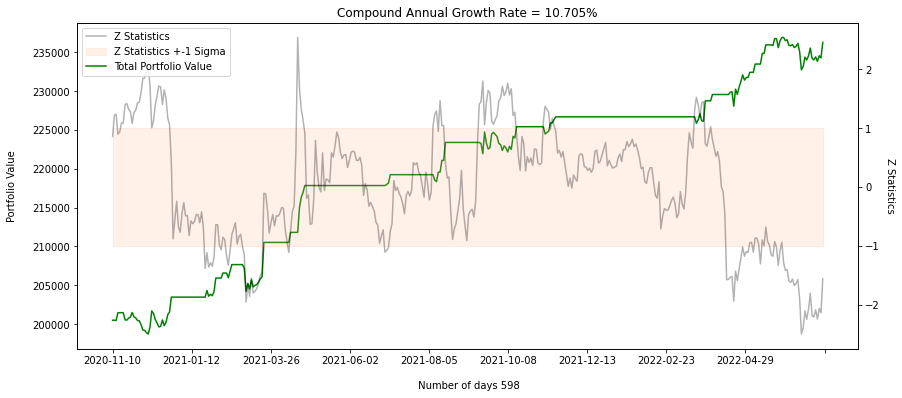

In [50]:
# plot the asset value change of the portfolio and z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
tick_spacing = portfolio['total asset'].index.size/9 # x
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
l2, = ax2.plot(portfolio['Z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['Upper limit'],\
                portfolio['Lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.xaxis.labelpad=15
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

#transform datetime format
date_last=datetime.strptime(portfolio.index[-1], "%Y-%m-%d")
date_first=datetime.strptime(portfolio.index[0], "%Y-%m-%d")
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (date_last - date_first).days
datelist=(' Number of days {}'.format(delta))
ax.set_xlabel(datelist)
YEAR_DAYS = 365
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1 #if delta>356(YEAR_DAYS/delta),delta<365(delta/YEAR_DAYS)  1
plt.title('Compound Annual Growth Rate = {:.3f}%' .format(returns * 100))